In [1]:
#gpu_id = 0
import data_handler
import dilated_model as DM
import trainer as T
import numpy as np
import torch as th
from torch.autograd import Variable
import sys, os
#os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
from os.path import basename, splitext
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 10]

th.multiprocessing.set_sharing_strategy('file_system')
name = splitext(basename(sys.argv[0]))[0]

global_transforms = [
    data_handler.Crop(9000),
]

transformationsA = [
    data_handler.Threshold(sigma=2.2),
    data_handler.RandomMultiplier(-1),
]

transformationsB = [
    data_handler.RandomMultiplier(-1),
    data_handler.Spectogram(31),
    #data_handler.Logarithm()
]

dataset = data_handler.DataSet(
    'data/raw/training2017/REFERENCE.csv', data_handler.load_forked,
    global_transforms=global_transforms,
    fork_transforms={'time':transformationsA, 'freq':transformationsB},
    path='data/raw/training2017/',
    remove_unlisted=False, tokens=data_handler.atrif_tokens, remove_noise=True)
train_set, eval_set = dataset.disjunct_split(.9)
train_producer = th.utils.data.DataLoader(
    dataset=dataset, batch_size=5, shuffle=False,
    num_workers=0, collate_fn=data_handler.batchify_forked)
'''
scratch_net = DM.EncodeWideResNet(in_channel=1, init_channel=32, 
    num_enc_layer=4, N_res_in_block=1, use_selu=True)


loaded_net = DM.EncodeWideResNet(in_channel=1, init_channel=32, 
    num_enc_layer=4, N_res_in_block=1, use_selu=True)
'''

'\nscratch_net = DM.EncodeWideResNet(in_channel=1, init_channel=32, \n    num_enc_layer=4, N_res_in_block=1, use_selu=True)\n\n\nloaded_net = DM.EncodeWideResNet(in_channel=1, init_channel=32, \n    num_enc_layer=4, N_res_in_block=1, use_selu=True)\n'

In [2]:
dataiter = iter(train_producer)
raw_data = next(dataiter)
#test_data = Variable(raw_data['x'].float())[None]

In [3]:
timeNet = DM.EncodeWideResNet(in_channel=1, init_channel=16, 
    num_enc_layer=4, N_res_in_block=1, use_selu=True)
timeNet.load_state_dict(th.load('time-params.pt'))

freqNet = DM.SkipFCN(in_channel=16, use_selu=True,
    channels=[16,16,  32,32,  64,64,64,  128,128,128,  128,128,128])
freqNet.load_state_dict(th.load('freq-params.pt'))

classifier = th.nn.Sequential(th.nn.BatchNorm1d(256), DM.SELU(), th.nn.Conv1d(256, 3, 1))
#classifier = th.nn.Conv1d(256, 3, 1)
net = DM.CombinedTransform(
#    pretrained=True,
    pretrained=False,
    feature_length=20, 
    time=timeNet, 
    freq=freqNet, 
    classifier=classifier)

In [4]:
net.load_state_dict(th.load('saved/TimeANDFreq-95/0001/state_dict_highscore'))

In [7]:
#res = net.forward_features(raw_data['x'])
res = net(raw_data['x'])
res.size()

torch.Size([5, 3])

In [8]:
plt.imshow(res.data.cpu().numpy()[0], aspect='auto', interpolation='None')
plt.colorbar()
plt.show()

TypeError: Invalid dimensions for image data

In [18]:
lens = raw_data['A']['x'].size(-1)
th.nn.MaxPool1d(kernel_size=lens//30, stride=None)(raw_data['A']['x']).size()

KeyError: 'A'

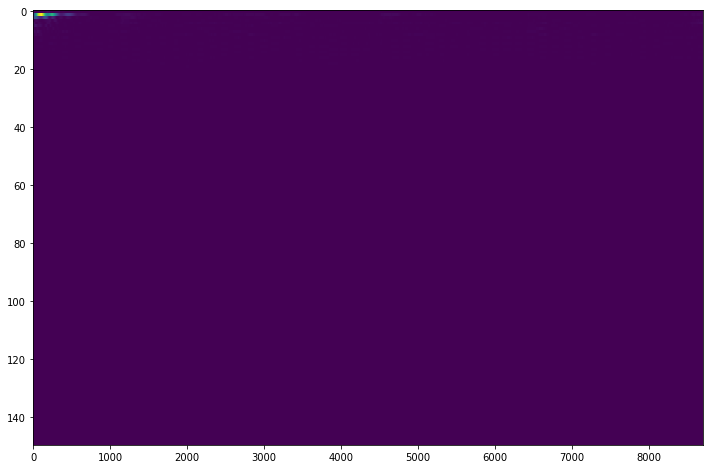

In [39]:
plt.imshow(raw_data['x'][0].numpy(), aspect='auto')
plt.show()

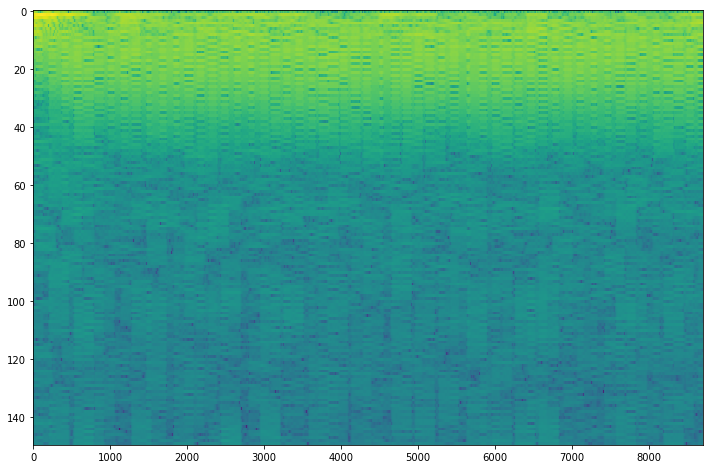

In [43]:
plt.imshow(raw_data['x'][0].numpy(), aspect='auto')
plt.show()

In [52]:
np.ones(888).copy()

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [10]:
print(loaded_res.max(2))
print(loaded_res.max(2)[0].max(1)[1][0, 0, 0].data.tolist()[0])

NameError: name 'loaded_res' is not defined

CPU times: user 4.29 s, sys: 165 ms, total: 4.45 s
Wall time: 119 ms
CPU times: user 3.89 s, sys: 133 ms, total: 4.03 s
Wall time: 106 ms
Fibrillation


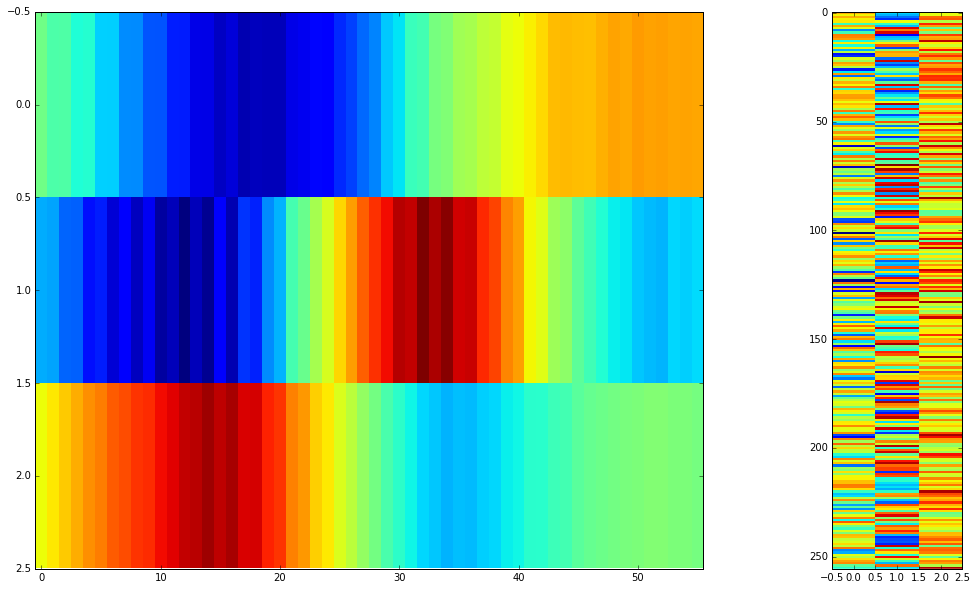

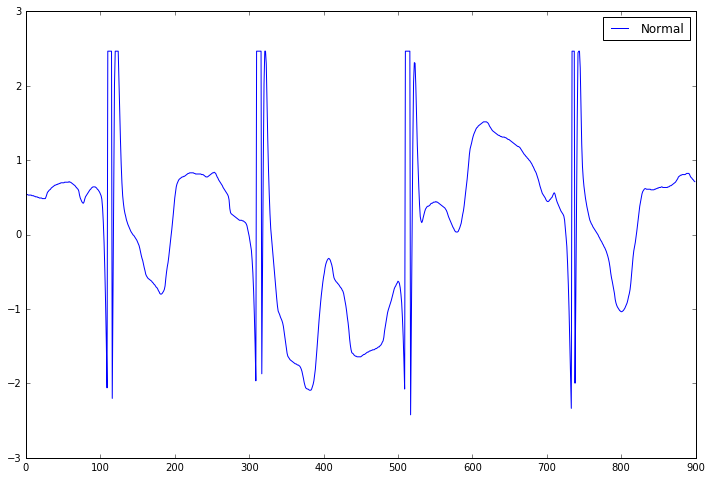

Fibrillation


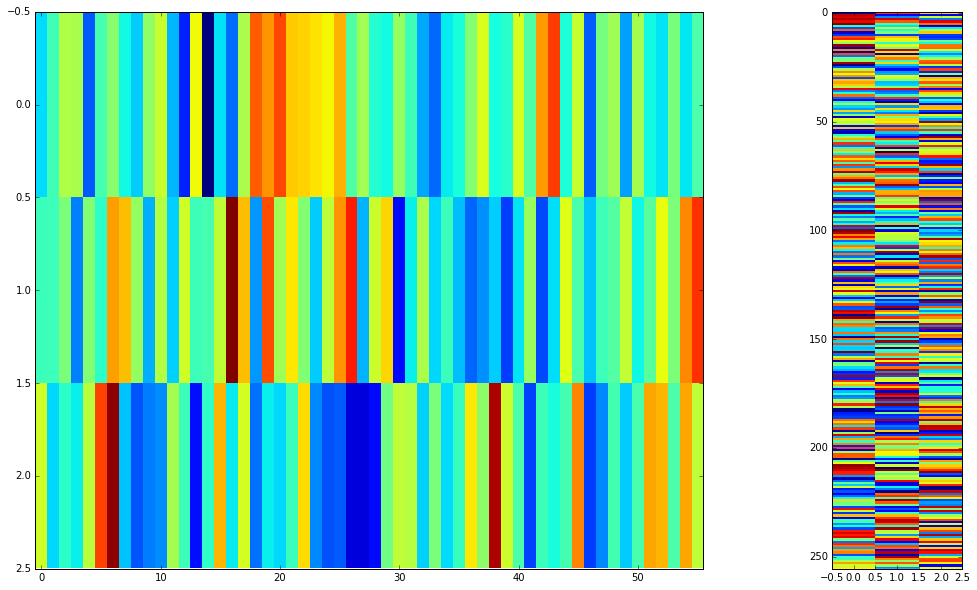

In [64]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8]
#raw_data = next(dataiter)
test_data = Variable(-raw_data['x'].float())[None]
%time scratch_res = scratch_net.logit(scratch_net.forward_features(test_data))
%time loaded_res = loaded_net.logit(loaded_net.forward_features(test_data))

scratch_choice = scratch_res.max(2)[0].max(1)[1][0, 0, 0].data.tolist()[0]
loaded_choice = loaded_res.max(2)[0].max(1)[1][0, 0, 0].data.tolist()[0]

#%time scratch_res = scratch_net.forward_features(test_data)
#%time loaded_res = (loaded_net.forward_features(test_data))


plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.imshow(scratch_res.data.numpy()[0], interpolation='None', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(scratch_net.logit.weight.squeeze().data.numpy().T, aspect=.05, interpolation='None')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
print(['Normal', 'Fibrillation', 'Other'][scratch_choice])
plt.show()

plt.plot(test_data.cpu().data.numpy()[0, 0], label=['Normal', 'Fibrillation', 'Other'][raw_data['y']])
plt.legend()
plt.show()


plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.imshow(loaded_res.data.numpy()[0], interpolation='None', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(loaded_net.logit.weight.squeeze().data.numpy().T, aspect=.05, interpolation='None')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
print(['Normal', 'Fibrillation', 'Other'][loaded_choice])
plt.show()



CPU times: user 4.2 s, sys: 174 ms, total: 4.38 s
Wall time: 121 ms
CPU times: user 4.41 s, sys: 151 ms, total: 4.56 s
Wall time: 121 ms
Fibrillation


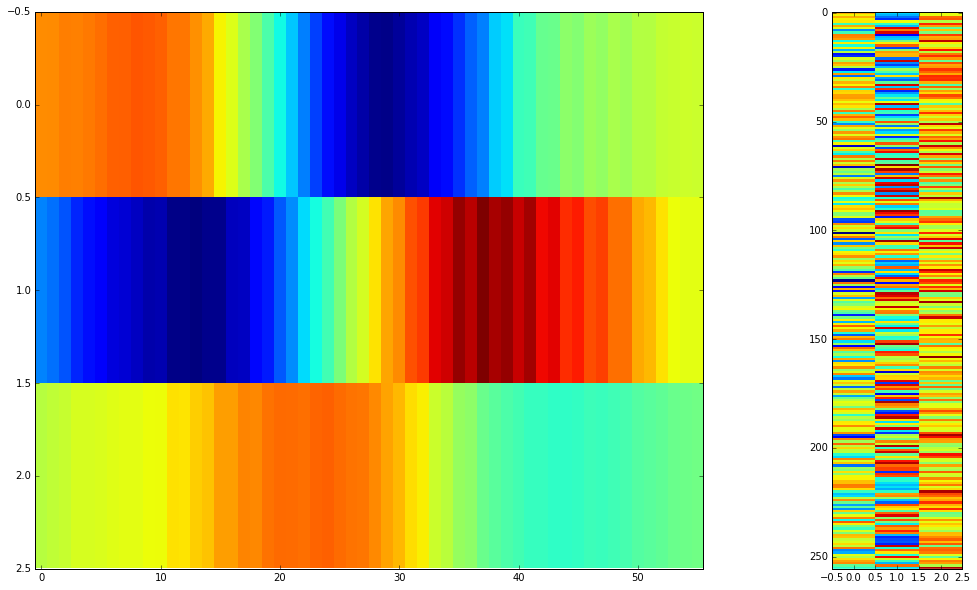

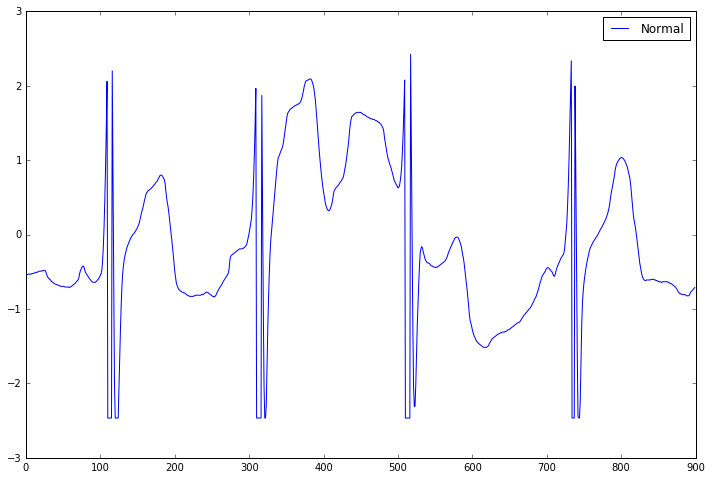

Normal


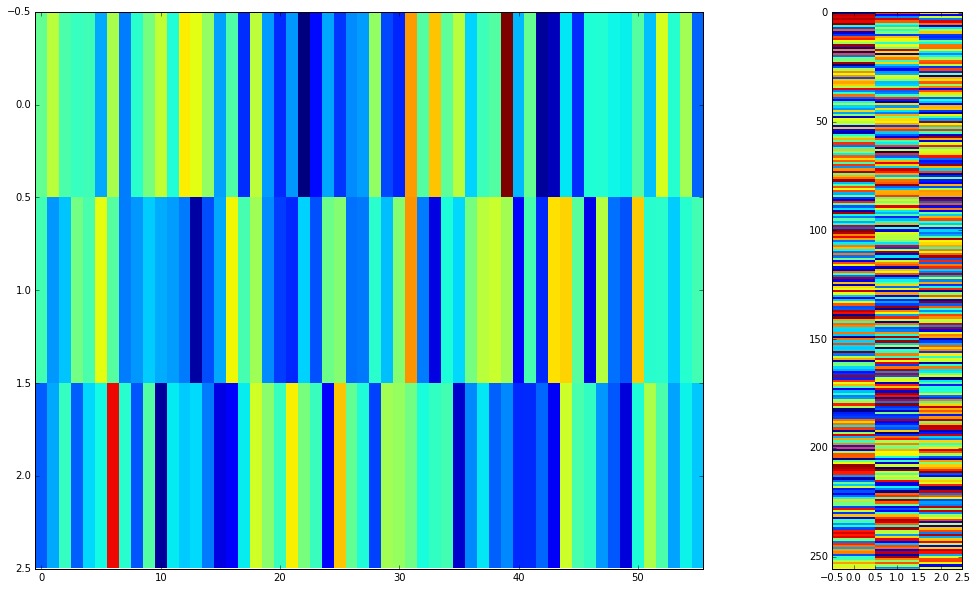

In [66]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8]
#raw_data = next(dataiter)
test_data = Variable(raw_data['x'].float())[None]
%time scratch_res = scratch_net.logit(scratch_net.forward_features(test_data))
%time loaded_res = loaded_net.logit(loaded_net.forward_features(test_data))

scratch_choice = scratch_res.max(2)[0].max(1)[1][0, 0, 0].data.tolist()[0]
loaded_choice = loaded_res.max(2)[0].max(1)[1][0, 0, 0].data.tolist()[0]

#%time scratch_res = scratch_net.forward_features(test_data)
#%time loaded_res = (loaded_net.forward_features(test_data))


plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.imshow(scratch_res.data.numpy()[0], interpolation='None', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(scratch_net.logit.weight.squeeze().data.numpy().T, aspect=.05, interpolation='None')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
print(['Normal', 'Fibrillation', 'Other'][scratch_choice])
plt.show()

plt.plot(test_data.cpu().data.numpy()[0, 0], label=['Normal', 'Fibrillation', 'Other'][raw_data['y']])
plt.legend()
plt.show()


plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.imshow(loaded_res.data.numpy()[0], interpolation='None', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(loaded_net.logit.weight.squeeze().data.numpy().T, aspect=.05, interpolation='None')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
print(['Normal', 'Fibrillation', 'Other'][loaded_choice])
plt.show()



CPU times: user 4.11 s, sys: 178 ms, total: 4.29 s
Wall time: 116 ms
CPU times: user 5.45 s, sys: 200 ms, total: 5.65 s
Wall time: 152 ms


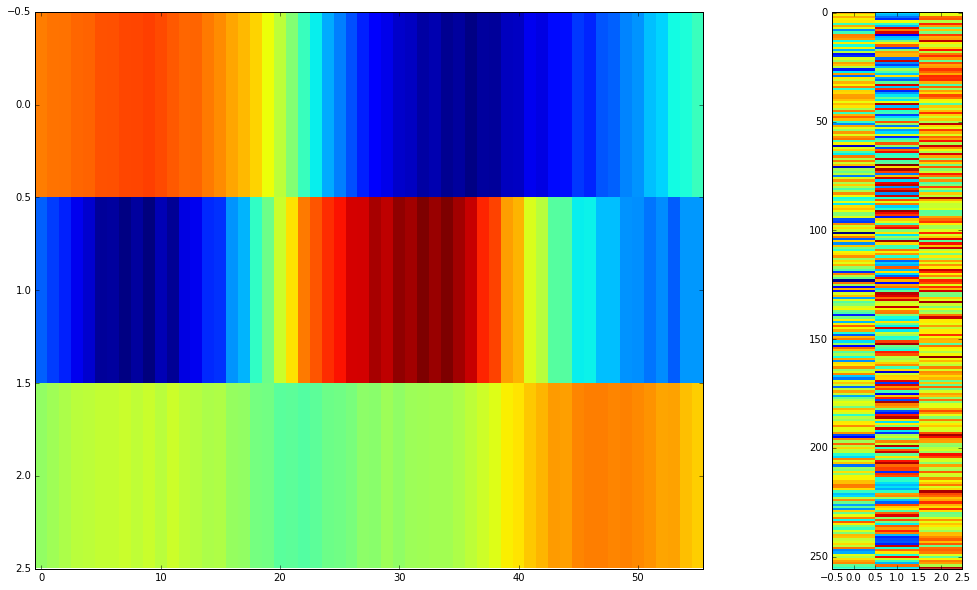

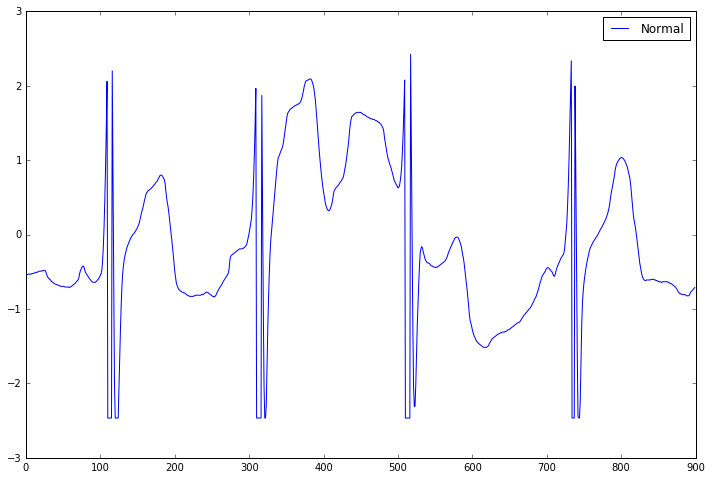

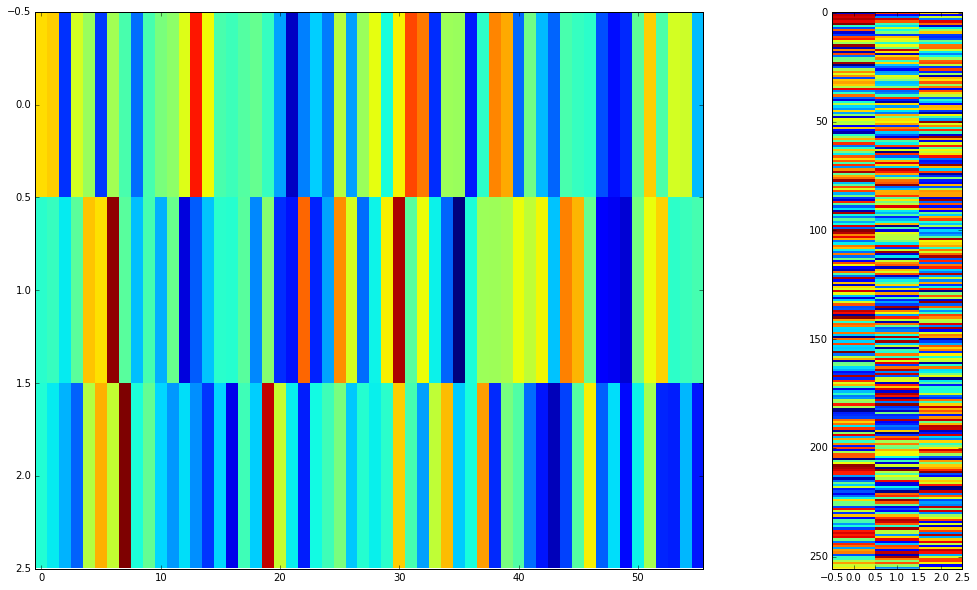

In [39]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8]
#raw_data = next(dataiter)
test_data = Variable(raw_data['x'].float())[None]
%time scratch_res = scratch_net.logit(scratch_net.forward_features(test_data))
%time loaded_res = loaded_net.logit(loaded_net.forward_features(test_data))
#%time scratch_res = scratch_net.forward_features(test_data)
#%time loaded_res = (loaded_net.forward_features(test_data))


plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.imshow(scratch_res.data.numpy()[0], interpolation='None', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(scratch_net.logit.weight.squeeze().data.numpy().T, aspect=.05, interpolation='None')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()

plt.plot(test_data.cpu().data.numpy()[0, 0], label=['Normal', 'Fibrillation', 'Other'][raw_data['y']])
plt.legend()
plt.show()


plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.imshow(loaded_res.data.numpy()[0], interpolation='None', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(loaded_net.logit.weight.squeeze().data.numpy().T, aspect=.05, interpolation='None')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

plt.show()



CPU times: user 6.73 s, sys: 289 ms, total: 7.02 s
Wall time: 183 ms
CPU times: user 4.18 s, sys: 163 ms, total: 4.35 s
Wall time: 114 ms


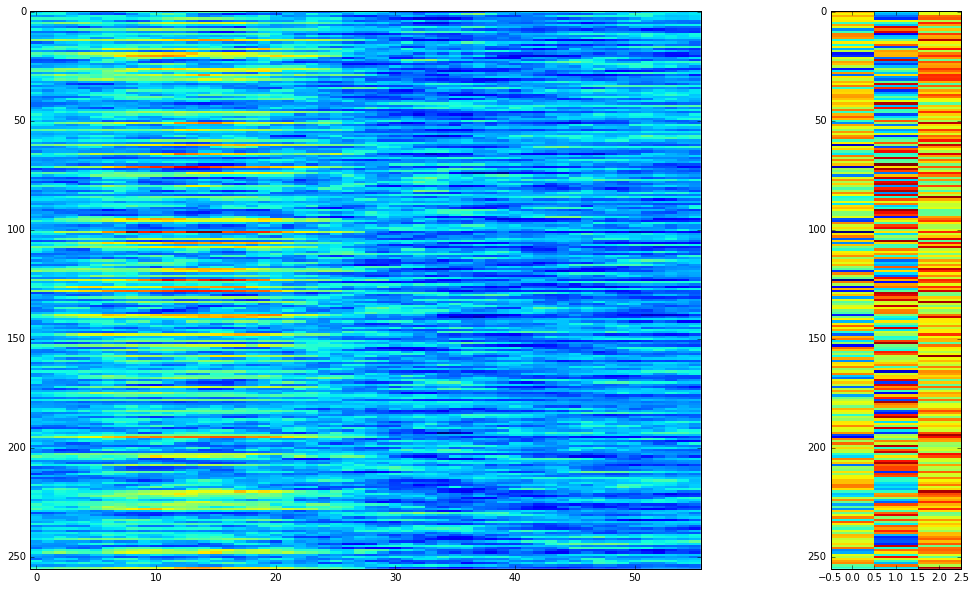

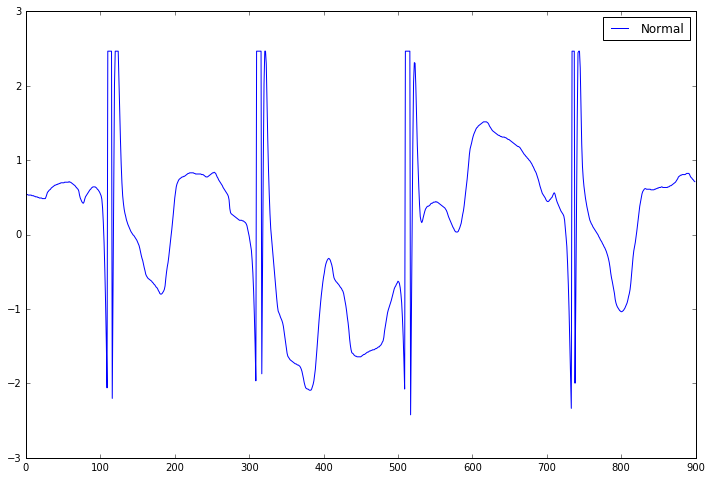

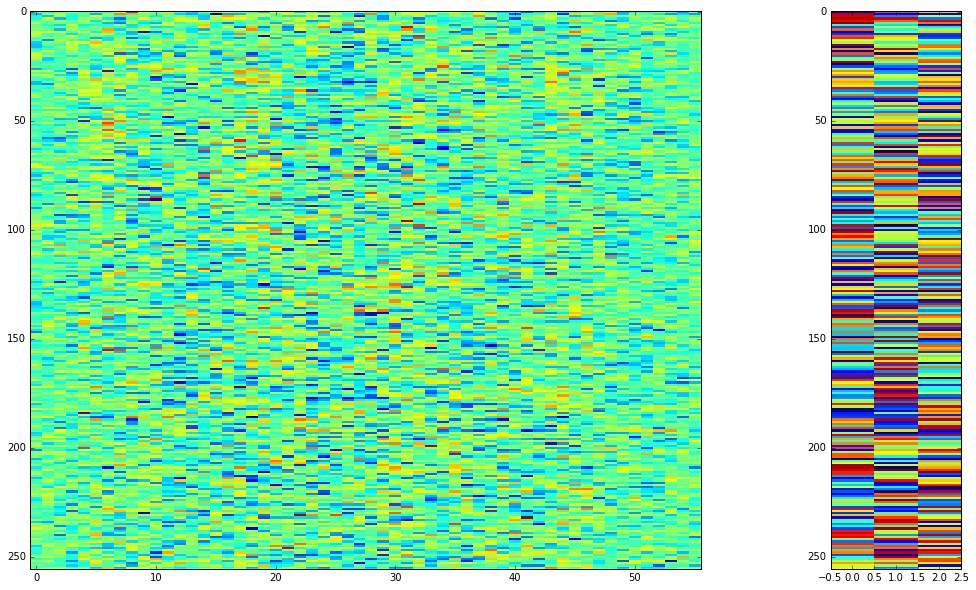

In [40]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8]
#raw_data = next(dataiter)
test_data = Variable(-raw_data['x'].float())[None]
#%time scratch_res = scratch_net.logit(scratch_net.forward_features(test_data))
#%time loaded_res = loaded_net.logit(loaded_net.forward_features(test_data))
%time scratch_res = scratch_net.forward_features(test_data)
%time loaded_res = (loaded_net.forward_features(test_data))


plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.imshow(scratch_res.data.numpy()[0], interpolation='None', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(scratch_net.logit.weight.squeeze().data.numpy().T, aspect=.05, interpolation='None')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()

plt.plot(test_data.cpu().data.numpy()[0, 0], label=['Normal', 'Fibrillation', 'Other'][raw_data['y']])
plt.legend()
plt.show()


plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.imshow(loaded_res.data.numpy()[0], interpolation='None', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(loaded_net.logit.weight.squeeze().data.numpy().T, aspect=.05, interpolation='None')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()



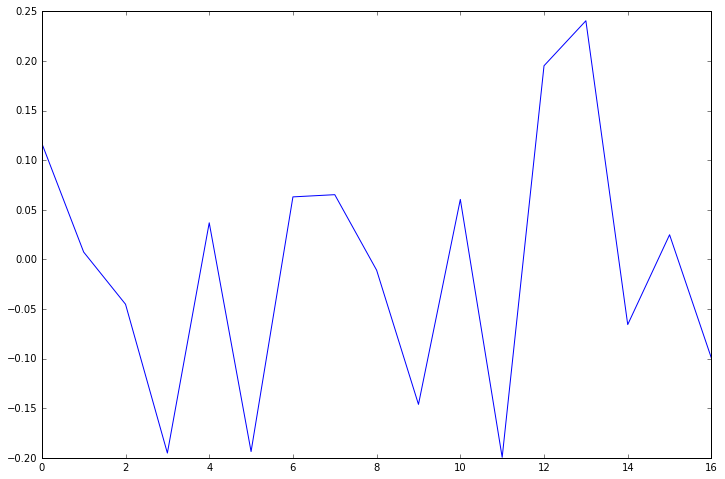

In [102]:
plt.plot(loaded_net.conv_init.weight[0].data.numpy().squeeze().T)
plt.show()

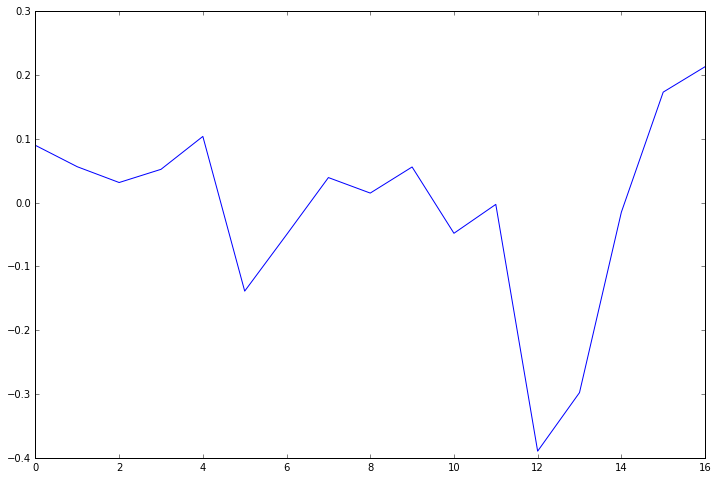

In [103]:
plt.plot(scratch_net.conv_init.weight[0].data.numpy().squeeze().T)
plt.show()

In [115]:
loaded_net.net[:3]

TypeError: unorderable types: slice() < int()

In [19]:
%%timeit
res = net.forward_features(test_data)

11.5 ms ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%%time
res = net.forward_features(test_data).cpu()

CPU times: user 17.7 ms, sys: 3.95 ms, total: 21.6 ms
Wall time: 20.9 ms
